In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

In [4]:
#Preparing the file
with open(r"C:\Users\emmag\Documents\astro 19\ASTR19_S22_group_project_data.txt") as file:
    data = file.read()
    
def parse_tide_data(data):
    rows = []
    for line in data.split('\n'):
        parts = line.split()
        if len(parts) == 3:
            day, time, height = parts
            rows.append({'Day': int(day), 'Time': time, 'Tide Height (feet)': float(height)})
            
    return pd.DataFrame(rows)
df = parse_tide_data(data)

# converting time and hours to a decimal point
def time_to_hours(t):
    hours, minutes = map(int, t.split(':'))
    return hours + minutes / 60
df['Time (Hours)'] = df['Time'].apply(time_to_hours)
# creating a standardized timestamp that can be plotted on the x-axis
df['Timepoint'] = df['Day'] + df['Time (Hours)'] / 24

In [8]:
#We experimented with a 1-sine model, a 2-sine model, and a 3-sine model, and the 2-sine model gave up the best results.
def oscillatory_function(x, a1, b1, c1, d1, a2, b2, c2, d2):
    return a1*np.sin(b1*x+c1)+d1 + a2*np.sin(b2*x+c2)+d2

parameters = [5, 0.5, 0, 0,   5, 2*np.pi, 1, 0]

#Now fitting the curve to the data...with mixed success, unfortunately.
params, params_cov = optimize.curve_fit(oscillatory_function, df['Timepoint'], df['Tide Height (feet)'],
                      sigma=np.full(len(df), 0.25),p0=parameters)

fit = oscillatory_function(df['Timepoint'], *params)

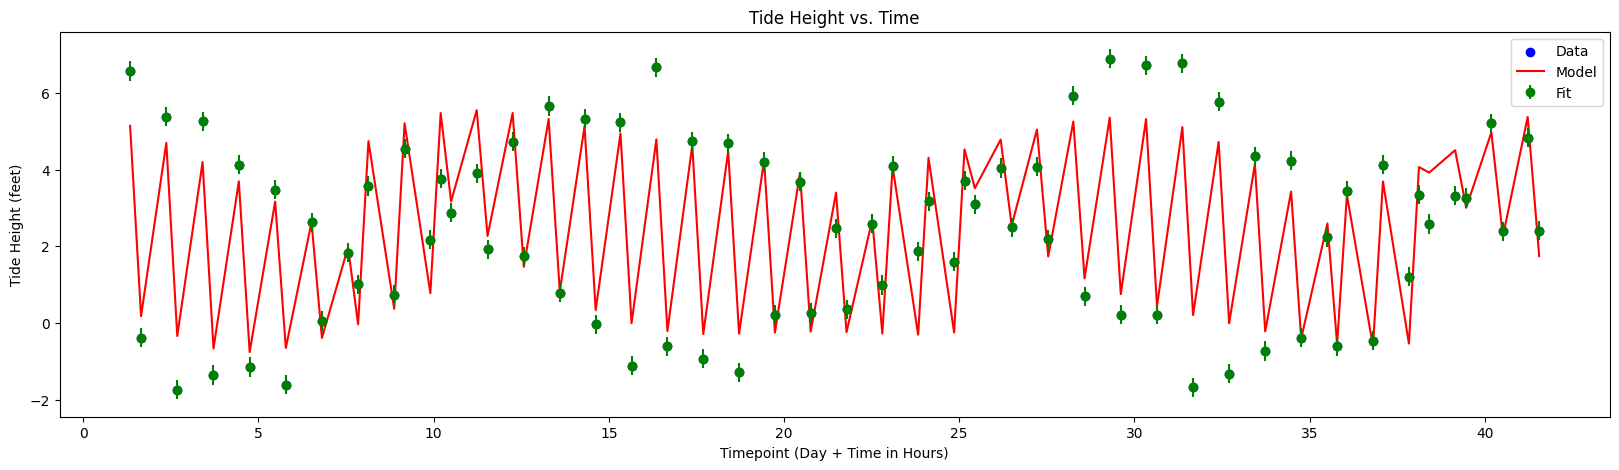

In [9]:
y_err=np.full(82,.25)
plt.figure(figsize=(20, 5))
plt.scatter(df['Timepoint'], df['Tide Height (feet)'], label='Data', color='blue')
plt.plot(df['Timepoint'], fit, label='Model', color='red') 
plt.errorbar(df['Timepoint'], df['Tide Height (feet)'],yerr=y_err,fmt='o', label='Fit', color='green')

plt.xlabel('Timepoint (Day + Time in Hours)')
plt.ylabel('Tide Height (feet)')
plt.title('Tide Height vs. Time')
plt.legend()

I think that the data needed a third sine function, but no matter what parameters I used, I couldn't get it to behave. 

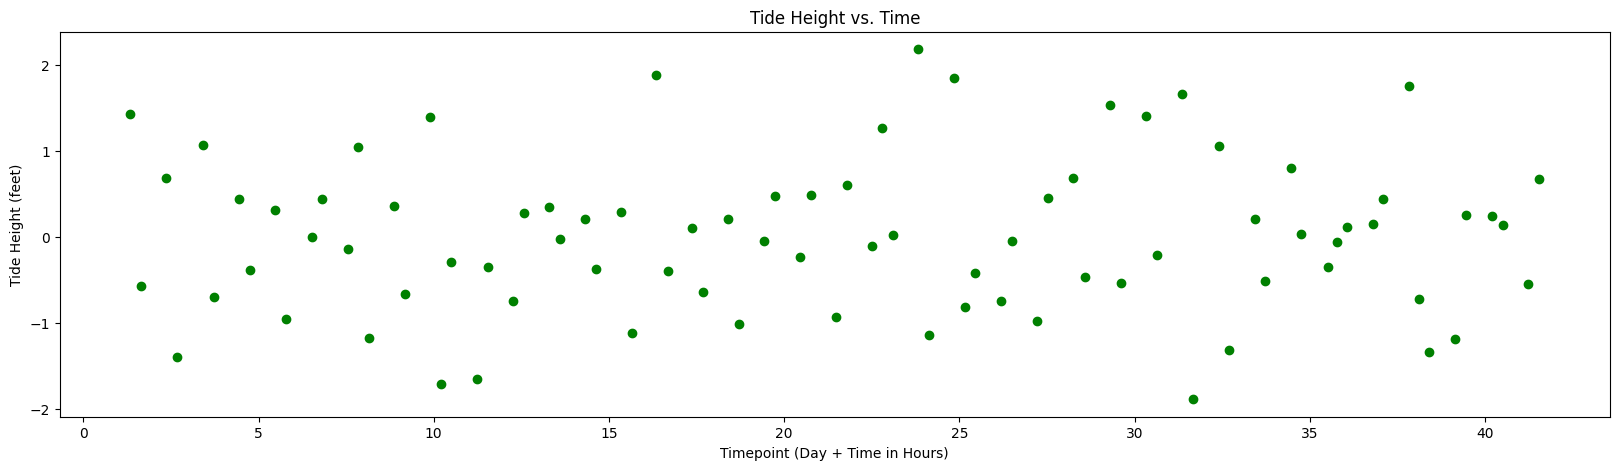

In [13]:
#The residuals.

sub = df['Tide Height (feet)']-fit
plt.figure(figsize=(20,5))
plt.scatter(df['Timepoint'],sub,color="green")
plt.xlabel('Timepoint (Day + Time in Hours)')
plt.ylabel('Tide Height (feet)')
plt.yticks(ticks=(np.arange(-2,3,1)))
plt.title('Tide Height vs. Time')
plt.show()